In [236]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from collections import Counter

19 years ago, I was an incident analyst at the CERT/CC during the Code Red worm outbreak. In the years that followed, I studied and modeled the spread of worms like Code Red, Nimda, Slapper, and Slammer on the internet. This involved not just understanding exponential growth, but the saturation that occurs as the spreading agent starts to run out of new victims. 

Since then I've done more and more modeling and simulation of complex systems in order to understand how the various moving parts interact and what you can do to change them. Yes, you can eventually reach an understanding of these things with math, but to me that's step 2: after you observe the dynamics of the model it's often easier to think about the math underlying it. Step 1 is to build and run a model to get a sense of what it does.

Today I'm applying what I learned then to build an agent-based model of a small epidemic spreading in a susceptible population.

# Dramatis Personae 
We're going to tell a story about people, so let's start by defining a person.

Our person is rather simple. They are represented by three variables. 
1. A person's state indicates their infection status. This can be 'susceptible', 'infected', 'recovered', or 'dead'.
2. A living person's location can be 'home', 'hospital', or 'icu'. If they die, their location will go to "None".
3. A person's severity can be 'mild','serious','critical'. Before they are infected, their severity will be "None".

We'll also set up some logical properties for the person. A person is
* alive if their state is not "dead"
* susceptible if their state is "susceptible"
* infected if their state is "infected"
* home if their location is "home"
* spreading if they are infected and their location is not "icu"
* hospitalizable if they are infected and their location is "home"
* hospitalized if their location is "hospital" (note that this excludes "icu")
* in icu if their location is "icu"

Okay, enough description, let's code it up.

In [237]:
class Person(object):
    states = [ 'susceptible', 'infected', 'recovered', 'dead', ]
    locations = ['home', 'hospital', 'icu']
    severities = ['mild','serious','critical'] 
    
    def __init__(self):
        self.state = 'susceptible'
        self.location = 'home'
        self.severity = None
        self.history = []
       
    @property
    def is_alive(self):
        return self.state != 'dead'
    
    @property
    def is_susceptible(self):
        return self.state == 'susceptible'

    @property
    def is_infected(self):
        return self.state == 'infected'

    @property
    def is_home(self):
        return self.location == 'home'
    
    @property
    def is_spreading(self):
        # assume if in icu people are adequately isolated
        return (self.is_infected and not self.is_in_icu)
    
    @property
    def is_hospitalizable(self):
        return (self.is_infected and self.is_home)

    @property
    def is_hospitalized(self):
        return self.location == 'hospital'

    @property
    def is_in_icu(self):
        return self.location == 'icu'

First, we need a way to keep a history of each person's data, so we'll make a little function to record the data into a history.

In [238]:
def record_history(person):
    entry = {
        'state': person.state,
        'location': person.location,
        'severity': person.severity,
    }
    person.history.append(entry)

But the person we just defined doesn't have any dynamics. They are just a collection of facts about their status, which will remain static unless we make something happen. So let's set up some things that can happen to our people.

* if a person is susceptible, they can be *infected*, which changes their state to "infected" and their severity to "mild"
* if a person is infected, they can *recover*, which changes their state to "recovered" and their location to "home"
  * or, if they are infected and at home, they can be *hospitalized*, which changes their location to "hospital" and their severity to "serious"
  * or if they are infected no matter their location, they can *die*, which changes their state to "dead" and their location to "None"
* if a person is hospitalized, they can be moved to the *icu*, which changes their location to "icu" and their severity to "critical"



In [239]:
def infect(person):
    # can only infect susceptibles
    if not person.is_susceptible:
        return
    
    person.state = 'infected'
    person.severity = 'mild'

def recover(person):
    # can only recover if infected
    if not person.is_infected:
        return
    
    person.state = 'recovered'
    
def die(person):
    # can only die if infected
    if not person.is_infected:
        return
    
    person.state = 'dead'
    person.location = None
    
def hospitalize(person):
    # you can only hospitalize the infected at home
    if not person.is_infected:
        return
    if person.location != 'home':
        return
    
    person.location = 'hospital'
    person.severity = 'serious'
    
def icu(person):
    # can only go to icu if you're already hospitalized
    if not person.is_hospitalized:
        return
    
    person.location = 'icu'
    person.severity = 'critical'

def recover(person):
    if not person.is_infected:
        return
    
    person.state = 'recovered'
    person.location = 'home'

Okay, so now we have a model of a person and the things that can happen to them. But those things don't just happen automatically. We're going to need to set up the mechanisms for our people to go about their daily lives.

Here is where we need to start setting some parameters for the model we're building.

* *n_people* is the size of our population. Let's say it's 1000 people. (I want this to run in a reasonable amount of time on an older resource-constrained machine.)
* *sim_duration* is the number of days we're going to simulate. We'll do a year.
* *daily interactions* is the number of people each person in our model interacts with on a daily basis. We'll just arbitrarily set this to 15 to keep things simple.
* *p_contagious_infects_susceptible* is the probability that an infected person will infect a susceptible person given an interaction. This doesn't happen all that often in our model, so we'll give it a 1% chance per interaction.
* *p_infected_hospitalized* is the daily probability that an infected individual will be hospitalized. Again, this is rather low at 1%. (Each infected person with a mild case has a 1% chance of being hospitalized until they recover.)
* *p_hospitalized_icu* is the daily probability that a hospitalized person will become critical and require ICU treatment. This rate is fairly low too, as each hospitalized person has a 3% chance of going into the ICU each day.
* *p_recovery_daily* is the daily probability that any infected person (regardless of location) will recover. In our model recovery is spontaneous and total. This is also set to 3%.

Now unfortuntately, death is a factor in our model. But a person's probability of dying given that they are infected is different depending on how severe their infection is.
* *p_icu_dies* is the daily probability that a patient in the ICU dies. We'll set that to 1 in 50, or 2%.
* *p_hospitalized_dies* is the daily probability that a hospitalized (non-ICU) patient dies. 1 in 100, 1%.
* *p_infected_dies* is the daily probability that a person with a mild case (at home) dies. 1 in 1000, 0.1%.

We also need to talk about societal resources like hospital beds and icu beds. We're going to model a very rich society that has 80 hospital beds per 1000 population. (Most real societies have 3-15 per 1000.) ICU beds tend to run around 10% of total beds, so we'll assume that too.

In [240]:
n_people = 1000
sim_duration = 365

daily_interactions = 15
p_contagious_infects_susceptible = 0.01
p_infected_hospitalized = 0.03
p_hospitalized_icu = 0.03
p_recovery_daily = 0.03

p_icu_dies = 0.02
p_hospitalized_dies = 0.01
p_infected_dies = 0.001

# real world is more like 3/1000-15/1000
hosp_beds_per_capita = 80/1000

available_beds = hosp_beds_per_capita * n_people
# ~10% of hosp beds are icu beds
icu_beds = available_beds * 0.1
# correct the bed count for icu beds
available_beds -= icu_beds

Now we have to build the probabilistic functions that will actually do the work in our simulation. There isn't all that much going on in most of these. 

A day in the life of each person goes like this:
* if they are susceptible, maybe they get infected
* if they are infected, maybe they recover, die, or are hospitalized
* if they are hospitalized, maybe they go to the ICU

For each susceptible person we'll just pick a random sample of everyone else for them to interact with each day. Then we just roll the dice and see if there is transmission. 

For those that are infected, as we mentioned above, the risk of dying depends on the severity of the illness in the patient. So we need to build a bit of logic into the "maybe_die" function for that. 

Everything else is fairly straghtforward.

In [241]:
def maybe_infect(person,people):
    
    alive = [p for p in people if p.is_alive]
    n_contacts = min(daily_interactions,len(alive))
    
    contacts = np.random.choice(alive,n_contacts)
    
    for contact in contacts:
        if contact.is_spreading:
            if np.random.uniform() < p_contagious_infects_susceptible:
                infect(person)
           
def maybe_hospitalize(person):
    if np.random.uniform() < p_infected_hospitalized:
        hospitalize(person)

def maybe_icu(person):
    if np.random.uniform() < p_hospitalized_icu:
        icu(person)
        
def maybe_recover(person):
    if np.random.uniform() < p_recovery_daily:
        recover(person)

def maybe_die(person):
    if person.is_in_icu:
        if np.random.uniform() < p_icu_dies:
            die(person)
    elif person.is_hospitalized:
        # not in icu but in hospital
        if np.random.uniform() < p_hospitalized_dies:
            die(person)
    elif person.is_infected:
        # not in icu, not in hospital, but infected
        if np.random.uniform() < p_infected_dies:
            die(person)
            
def day_in_the_life(person,people):
    # infect, recover, or die
    if person.is_susceptible:
        maybe_infect(person,people)
    elif person.is_infected:
        maybe_recover(person)
        maybe_die(person)
    
    # go to the hospital or icu
    if person.is_hospitalizable:
        maybe_hospitalize(person)
    elif person.is_hospitalized:
        maybe_icu(person)

We're almost ready to run our simulation. One last stop on the way there is to create a few functions that help us with that. We need to 

* generate our population
* collect stats about our population
* gather a daily summary of our population stats including some derived metrics

In [242]:
def gen_people(n):
    people = []
    for i in range(n):
        p = Person()
        people.append(p)
    return people
    
def collect_stats(people):
    states = Counter()
    locations = Counter()
    severity = Counter()
    active_sev = Counter()
    other = Counter()
    
    for p in people:
        record_history(p)
        
        states[p.state] += 1
        
        if p.location is not None:
            locations[p.location] += 1
        
        if p.severity is not None:
            severity[p.severity] += 1
        
            if p.is_infected:
                active_sev[p.severity] += 1
            
        if p.is_alive:
            other['pop'] += 1
        
        if not p.is_susceptible:
            other['tot_cases'] += 1
            
    return (states,locations,severity,active_sev,other)
    
def summarize(day,people,_print=False):
    (states,locations,severity,active_sev,other) = collect_stats(people)
    
    summary = {'day': day,}
    for k,v in states.items():
        k = f's_{k}'
        summary[k] = v
        
    for k,v in locations.items():
        k = f'l_{k}'
        summary[k] = v
        
    for k,v in severity.items():
        k = f'sv_{k}'
        summary[k] = v

    for k,v in active_sev.items():
        k = f'acsv_{k}'
        summary[k] = v

    for k,v in other.items():
        summary[k] = v
    
    summary['tot_hosp'] = summary.get('l_hospital',0) + summary.get('l_icu',0)
    
    if _print:
        print(summary)
    return summary

Almost there. Here's the function that will actually run our simulation.

1. Create a population.
2. Infect one "lucky" person.
3. Run through each day, having each person interact with others and live their life.
4. If at any point the number of infected drops to zero, the simulation run ends.

In [243]:
def sim(n_people, n_days, n_lucky = 1):
    data = []
    people = gen_people(n_people)
    
    # randomly infect someone
    the_lucky = np.random.choice(people,n_lucky)
    for lucky in the_lucky: 
        infect(lucky)
    
    
    for day in range(n_days):
        summary = summarize(day,people)
        data.append(summary)
        if summary.get('s_infected',0) == 0:
            print("it's over!")
            break
            
        for p in people:
            day_in_the_life(p,people)                

    return data,people

At this point we're ready to actually run this thing. Sometimes the infection just burns out before it takes off, so we'll add a small loop to make sure we actually get an epidemic before we move on.

In [244]:
data = []
i = 0
while len(data) < 60:
    if i>0:
        print(f"No epidemic. Infections gone after {len(data)} days")
        
    i += 1
    print(f"Try {i}...")
    data,people = sim(n_people,sim_duration)

print(f"Infections gone after {len(data)} days")

Try 1...
it's over!
Infections gone after 258 days


Now that we have a successful run, we'll use pandas to do the remainder of the analysis.

In [245]:
df = pd.DataFrame(data)
df.fillna(0,inplace=True)
df.set_index('day',inplace=True)
sortcols = sorted(df.columns)
df = df[sortcols]

It'll help us to have some subsets of columns for plots.

In [246]:
all_cols = df.columns
hosp_cols = ['l_hospital', 'l_icu', 'tot_hosp']
sev_cols = [c for c in all_cols if c.startswith('acsv')]
status_cols = ['pop', 's_dead', 's_infected',
       's_recovered', 's_susceptible', 'sv_critical', 'sv_mild', 'sv_serious',
       'tot_cases',]

# Infection Trends

Let's start with an overview of the epidemic. A few interesting things pop out here. 

* The total cases follows a sigmoid curve. Exponential growth can't continue forever, and we see this as the total case count starts to slow its rise as the infection starts to run out of susceptible people to infect.
* The total number of mild cases over time peaks then drops as some of those mild cases become more severe.
* The death toll continues to rise beyond the apparent decrease in total case growth because there is a lag of some days between infection and death.

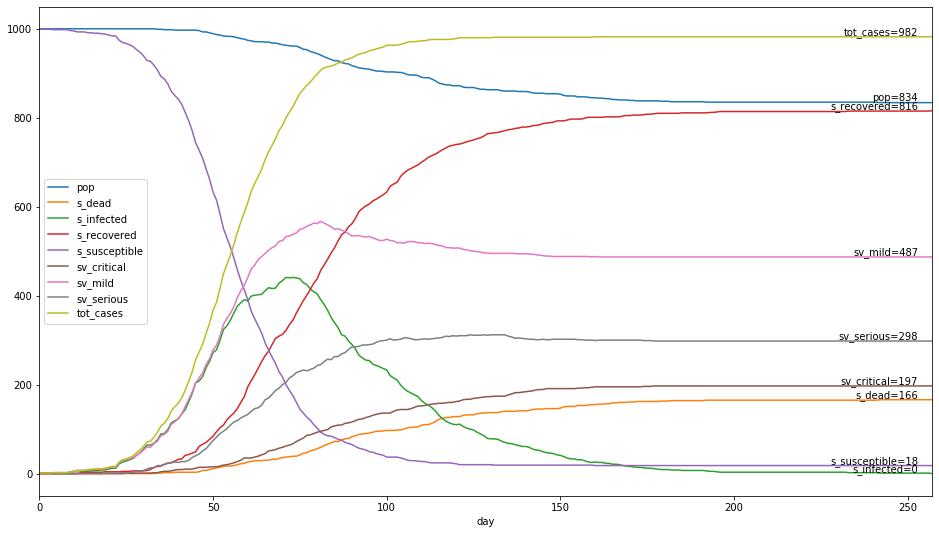

In [247]:
ax = df[status_cols].plot(figsize=(16,9))

for col in status_cols:
    val = int(df[col].iloc[-1])
    plt.text(len(df)-5,val+5,f"{col}={val}",horizontalalignment="right")
plt.legend()
plt.show()

# Case Severity by Day

When we look at the daily tallies of case severity, we see that the peak of serious cases lags that of mild cases, and the peak of serious cases lags the peak of serious ones. This not surprising as the lag is an inherent property of the model, which assumes that mild cases transition to serious, and that serious cases transition to critical. 

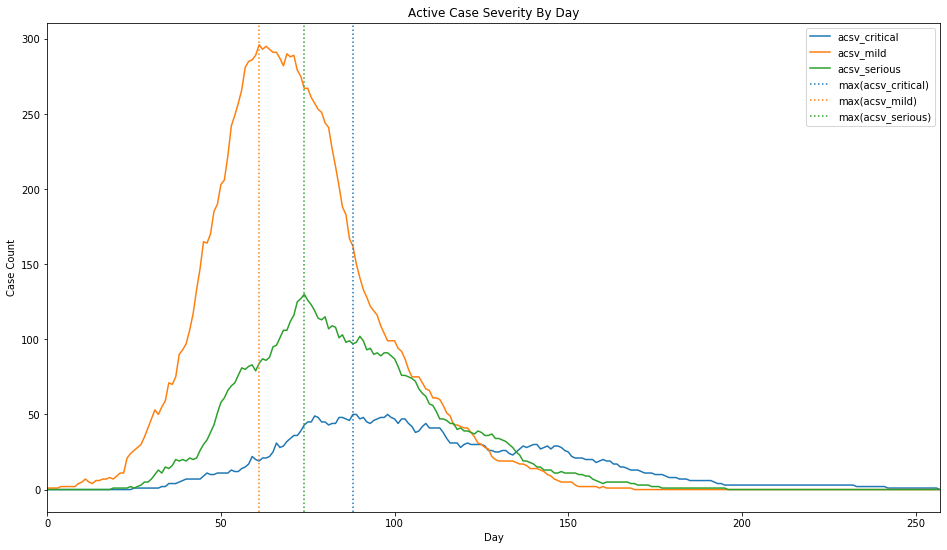

In [248]:
# just getting the color list so we can use it to draw lines
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax = df[sev_cols].plot(figsize=(16,9))
ax.set_title("Active case severity by day".title())
ax.set_ylabel("case count".title())
ax.set_xlabel("day".title())
for i,col in enumerate(sev_cols):
    color = colors[i]
    ax.axvline(df[col].idxmax(),color=color,ls=":",label=f"max({col})")
plt.legend()
plt.show()

# Hospital Availability

Next we take a look at hospital bed availability. As expected from the above examination of severity, we can immediately see that the number of cases in ICU lags the number of hospitalized (non-ICU) cases. 

But we can also see a couple of problems. There are a finite number of ICU beds. And these are exceeded fairly early in the simulation, and the demand outstrips supply for a long time. After the ICU beds run out, the demand for non-ICU hospital beds also exceeds the supply as well. The demand surge for hospital beds in general abates sooner than the demand for ICU beds. But this model doesn't account for secondary effects of patients being turned away or standards of care decreasing as the number of patients grows.

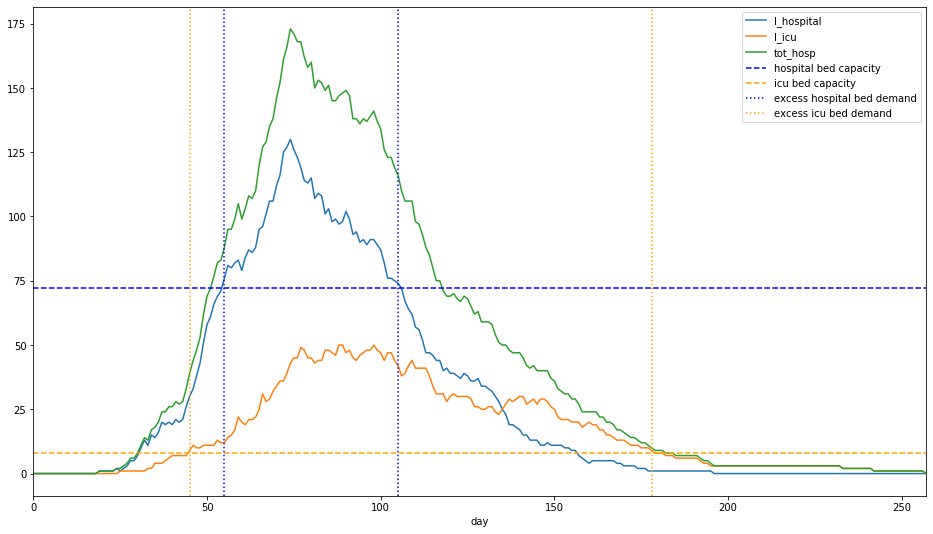

In [249]:
ax = df[hosp_cols].plot(figsize=(16,9))
ax.axhline(available_beds,color="blue",ls="--",label="hospital bed capacity")
ax.axhline(icu_beds,color="orange",ls="--",label="icu bed capacity")

x1 = df['l_hospital'][df['l_hospital'] > available_beds].index[0]
ax.axvline(x1,color="blue",ls=":",label="excess hospital bed demand")
x2 = df['l_hospital'][df['l_hospital'] > available_beds].index[-1]
ax.axvline(x2,color="blue",ls=":")

x3 = df['l_icu'][df['l_icu'] > icu_beds].index[0]
ax.axvline(x3,color="orange",ls=":",label="excess icu bed demand")
x4 = df['l_icu'][df['l_icu'] > icu_beds].index[-1]
ax.axvline(x4,color="orange",ls=":")
    
plt.legend()
plt.show()

# Flatten the curve

There is a good bit of discussion about the effects of reducing social contact on the intensity / duration of excess demand for health care services. We can simulate that here by re-running our simulation with a lower number of daily interactions. So let's try the exact same simulation (all other parameters equal to the above) but this time with the daily interaction count down to 6 (from 15).

In [250]:
daily_interactions = 6

data = []
i = 0
while len(data) < 100:
    if i>0:
        print(f"No epidemic. Infections gone after {len(data)} days")
        
    i += 1
    print(f"Try {i}...")
    data,people = sim(n_people,sim_duration,n_lucky=20)

print(f"Simulation ended after {len(data)} days")

Try 1...
Simulation ended after 365 days


The first thing to take note of is with lower social connectivity it is harder for the epidemic to take off in the first place. So this time we start off with 20 infected individuals instead of just 1. This would also be equivalent to imposing social distancing measures after 20 people became infected.

In [251]:
df = pd.DataFrame(data)
df.fillna(0,inplace=True)
df.set_index('day',inplace=True)
sortcols = sorted(df.columns)
df = df[sortcols]

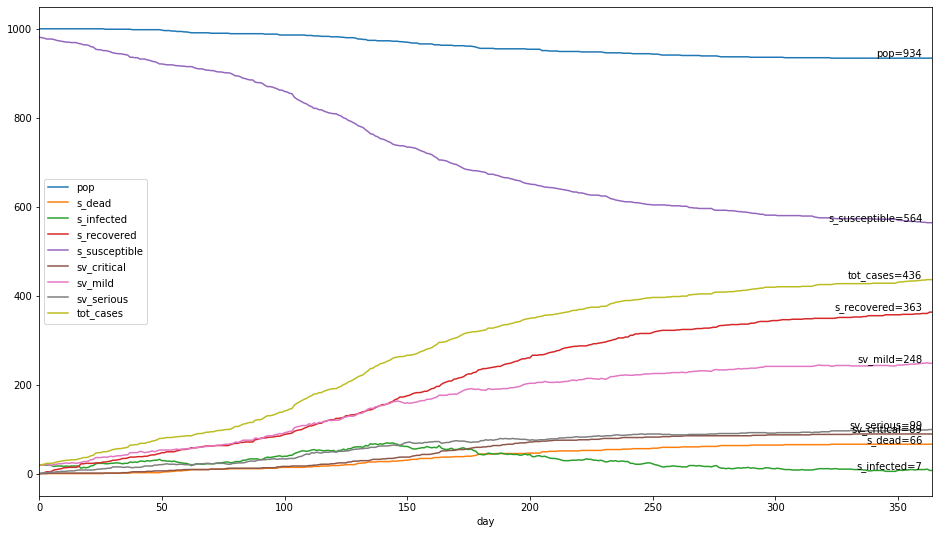

In [252]:
ax = df[status_cols].plot(figsize=(16,9))

for col in status_cols:
    val = int(df[col].iloc[-1])
    plt.text(len(df)-5,val+5,f"{col}={val}",horizontalalignment="right")
plt.legend()
plt.show()

Reducing connectivity lessens the slope of the infection rate.

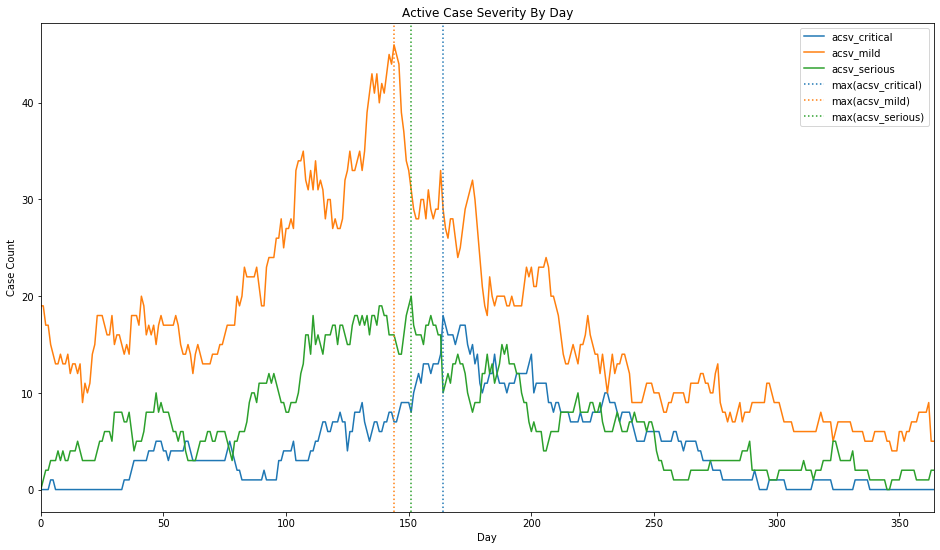

In [253]:
ax = df[sev_cols].plot(figsize=(16,9))
ax.set_title("Active case severity by day".title())
ax.set_ylabel("case count".title())
ax.set_xlabel("day".title())
for i,col in enumerate(sev_cols):
    color = colors[i]
    ax.axvline(df[col].idxmax(),color=color,ls=":",label=f"max({col})")
plt.legend()
plt.show()

The results aren't perfect. We still run out of ICU beds, but much later in the simulation than before. But we don't run out of hospital beds overall, either. Both of these things could mean time for the health care system to adapt and build capacity -- time it didn't have in the more connected model we ran first.

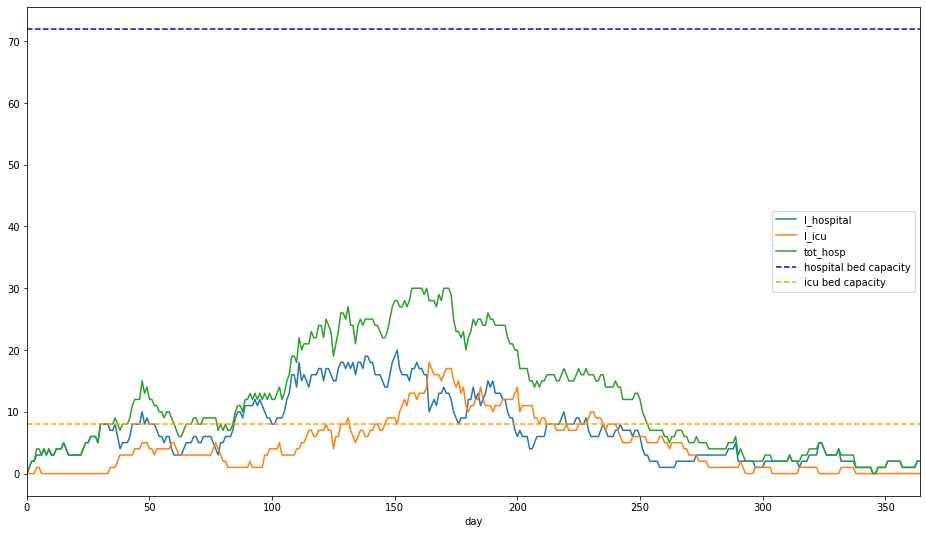

In [254]:
ax = df[hosp_cols].plot(figsize=(16,9))
ax.axhline(available_beds,color="blue",ls="--",label="hospital bed capacity")
ax.axhline(icu_beds,color="orange",ls="--",label="icu bed capacity")

plt.legend()
plt.show()

# Limitations

This is *not* a predictive model. I have made no attempt to tune its parameters to fit COVID-19 or any other historical epidemic. This model is an idea model to explore the dynamics of an epidemic in a small population. Although the probabilities and rates are inspired by real world situations, they are not representative of any particular epidemic. In some cases the numbers have been tweaked simply to ensure that the phenomenon of interest shows up in the model.

I created this model primarily to help myself make sense of how reported numbers in an actual outbreak might fit into what's really happening. Understanding the interplay between the variables helps one to develop better intuitions about what to watch out for and where to anticipate problems.

I'm sharing this because you might find it useful to do the same for yourself.